# Analysing mock datasets

In [115]:
# packages

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from itertools import combinations

import sys
sys.path.append("../src")

from analysis import *
from inference import *

In [2]:
import re

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)] 
    return sorted(l, key=alphanum_key)

In [3]:
datapath = "../experiment_outputs/test2/datasets/"
datafiles = os.listdir(datapath)
metadatafiles = [f"metadata{i.split('dataset')[1].split('csv')[0]}txt"\
                for i in datafiles]

datafiles = natural_sort(datafiles)
metadatafiles = natural_sort(metadatafiles)

In [4]:
df = pd.read_csv(datapath+datafiles[0], index_col=0)
metatext = open(f"{datapath}../metadata/"+metadatafiles[0], "r").read().split("\n")
df

,dataset,init_cond_idx,t_samp_dist_idx,measurement_noise,replicate,time,dt,sp1,sp2
0,0.0,0.0,0.0,0.0,0.0,0.000000,3.333333,0.432183,0.441384
1,0.0,0.0,0.0,0.0,0.0,3.333333,3.333333,0.424884,0.453830
2,0.0,0.0,0.0,0.0,0.0,6.666667,3.333333,0.510088,0.552791
3,0.0,0.0,0.0,0.0,0.0,10.000000,3.333333,0.489305,0.507222
4,0.0,0.0,0.0,0.0,0.0,13.333333,3.333333,0.381677,0.517997
...,...,...,...,...,...,...,...,...,...
295,19.0,4.0,1.0,0.1,0.0,23.684211,1.578947,0.410460,0.487839
296,19.0,4.0,1.0,0.1,0.0,25.263158,1.578947,0.419151,0.541748
297,19.0,4.0,1.0,0.1,0.0,26.842105,1.578947,0.526454,0.526271
298,19.0,4.0,1.0,0.1,0.0,28.421053,1.578947,0.367020,0.567186


In [5]:
def get_meta(metatext):
    meta = {}
    for n, line in enumerate(metatext):
        if "initial conditions" in line:
            init_cond_ln_idx = n

        elif "sampling timepoints" in line:
            t_samp_ln_idx = n

        elif "parameters" in line:
            meta["parameters"] = np.array([np.float64(j) for j in line.split(": ")[1].split(",")])
            params_ln_idx = n
        
        elif "measurement noise" in line:
            meta["meas_noise"] = np.array([np.float64(j) for j in line.split(": ")[1].split(",")])
            meas_noise_ln_idx = n
            break

    meta["init_cond"] = np.array([[np.float64(i) for i in metatext[j].split(",")] \
                                  for j in range(init_cond_ln_idx+1, t_samp_ln_idx)])

    meta["t_samp"] = [np.array([np.float64(i) for i in metatext[j].split(",")]) \
                                  for j in range(t_samp_ln_idx+1, params_ln_idx)]

    for i in range(meas_noise_ln_idx+1, len(metatext)-1):
        key, val = metatext[i].split(": ")
        meta[key] = np.float64(val)

    key, val = metatext[-1].split(": ")
    meta[key] = bool(val)

    return meta

In [6]:
metadict = get_meta(metatext)
metadict

{'parameters': array([ 0.5488135 ,  0.71518937, -1.6740246 ,  0.4105985 ,  0.14404357,
        -1.57456311]),
 'meas_noise': array([0. , 0.1]),
 'init_cond': array([[0.43218286, 0.44138427],
        [0.89498139, 0.30381701],
        [0.39472457, 0.19375925],
        [0.05414083, 0.55097219],
        [0.57845904, 0.20939048]]),
 't_samp': [array([ 0.        ,  3.33333333,  6.66666667, 10.        , 13.33333333,
         16.66666667, 20.        , 23.33333333, 26.66666667, 30.        ]),
  array([ 0.        ,  1.57894737,  3.15789474,  4.73684211,  6.31578947,
          7.89473684,  9.47368421, 11.05263158, 12.63157895, 14.21052632,
         15.78947368, 17.36842105, 18.94736842, 20.52631579, 22.10526316,
         23.68421053, 25.26315789, 26.84210526, 28.42105263, 30.        ])],
 'env_noise': 0.1,
 't0': 0.0,
 'dt': 0.001,
 'seed': 1.0,
 'repetitions': 1.0,
 'scale_meas_noise_by_abund': True}

In [7]:
df.columns

Index(['dataset', 'init_cond_idx', 't_samp_dist_idx', 'measurement_noise',
       'replicate', 'time', 'dt', 'sp1', 'sp2'],
      dtype='object')

In [12]:
print(f"No of initial conditions:", len(df.init_cond_idx.unique()))
print(f"No of sampling timepoint distributions:", len(df.t_samp_dist_idx.unique()))
print(f"Measurement noise values:", df.measurement_noise.unique())
print(f"No of replicates:", len(df.replicate.unique()))

No of initial conditions: 5
No of sampling timepoint distributions: 2
Measurement noise values: [0.  0.1]
No of replicates: 1


In [36]:
df[(df[["init_cond_idx", "t_samp_dist_idx"]]==[0, 0]).all(axis=1)]

,dataset,init_cond_idx,t_samp_dist_idx,measurement_noise,replicate,time,dt,sp1,sp2
0,0.0,0.0,0.0,0.0,0.0,0.000000,3.333333,0.432183,0.441384
1,0.0,0.0,0.0,0.0,0.0,3.333333,3.333333,0.424884,0.453830
2,0.0,0.0,0.0,0.0,0.0,6.666667,3.333333,0.510088,0.552791
3,0.0,0.0,0.0,0.0,0.0,10.000000,3.333333,0.489305,0.507222
4,0.0,0.0,0.0,0.0,0.0,13.333333,3.333333,0.381677,0.517997
5,0.0,0.0,0.0,0.0,0.0,16.666667,3.333333,0.472853,0.483785
6,0.0,0.0,0.0,0.0,0.0,20.000000,3.333333,0.492639,0.541117
7,0.0,0.0,0.0,0.0,0.0,23.333333,3.333333,0.438160,0.543196
8,0.0,0.0,0.0,0.0,0.0,26.666667,3.333333,0.492250,0.535362
9,0.0,0.0,0.0,0.0,0.0,30.000000,NaN,0.474573,0.482154


In [40]:
df["t_samp_dist_idx"]==0

0       True
1       True
2       True
3       True
4       True
       ...  
295    False
296    False
297    False
298    False
299    False
Name: t_samp_dist_idx, Length: 300, dtype: bool

In [64]:
df

,dataset,init_cond_idx,t_samp_dist_idx,measurement_noise,replicate,time,dt,sp1,sp2
0,0.0,0.0,0.0,0.0,0.0,0.000000,3.333333,0.432183,0.441384
1,0.0,0.0,0.0,0.0,0.0,3.333333,3.333333,0.424884,0.453830
2,0.0,0.0,0.0,0.0,0.0,6.666667,3.333333,0.510088,0.552791
3,0.0,0.0,0.0,0.0,0.0,10.000000,3.333333,0.489305,0.507222
4,0.0,0.0,0.0,0.0,0.0,13.333333,3.333333,0.381677,0.517997
...,...,...,...,...,...,...,...,...,...
295,19.0,4.0,1.0,0.1,0.0,23.684211,1.578947,0.410460,0.487839
296,19.0,4.0,1.0,0.1,0.0,25.263158,1.578947,0.419151,0.541748
297,19.0,4.0,1.0,0.1,0.0,26.842105,1.578947,0.526454,0.526271
298,19.0,4.0,1.0,0.1,0.0,28.421053,1.578947,0.367020,0.567186


In [121]:
list(combinations(df.init_cond_idx.unique(), 2))

[(0.0, 1.0),
 (0.0, 2.0),
 (0.0, 3.0),
 (0.0, 4.0),
 (1.0, 2.0),
 (1.0, 3.0),
 (1.0, 4.0),
 (2.0, 3.0),
 (2.0, 4.0),
 (3.0, 4.0)]

In [114]:
conditionals = df["init_cond_idx"].isin()
conditionals

0       True
1       True
2       True
3       True
4       True
       ...  
295    False
296    False
297    False
298    False
299    False
Name: init_cond_idx, Length: 300, dtype: bool

In [54]:
df[(df["init_cond_idx"]==0) * (df["t_samp_dist_idx"]==0)]

,dataset,init_cond_idx,t_samp_dist_idx,measurement_noise,replicate,time,dt,sp1,sp2
0,0.0,0.0,0.0,0.0,0.0,0.000000,3.333333,0.432183,0.441384
1,0.0,0.0,0.0,0.0,0.0,3.333333,3.333333,0.424884,0.453830
2,0.0,0.0,0.0,0.0,0.0,6.666667,3.333333,0.510088,0.552791
3,0.0,0.0,0.0,0.0,0.0,10.000000,3.333333,0.489305,0.507222
4,0.0,0.0,0.0,0.0,0.0,13.333333,3.333333,0.381677,0.517997
5,0.0,0.0,0.0,0.0,0.0,16.666667,3.333333,0.472853,0.483785
6,0.0,0.0,0.0,0.0,0.0,20.000000,3.333333,0.492639,0.541117
7,0.0,0.0,0.0,0.0,0.0,23.333333,3.333333,0.438160,0.543196
8,0.0,0.0,0.0,0.0,0.0,26.666667,3.333333,0.492250,0.535362
9,0.0,0.0,0.0,0.0,0.0,30.000000,NaN,0.474573,0.482154


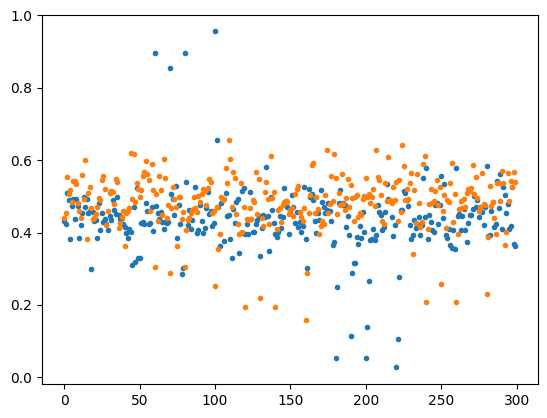

In [10]:
plt.plot(df[[i for i in df.columns if "sp" in i]], ".")

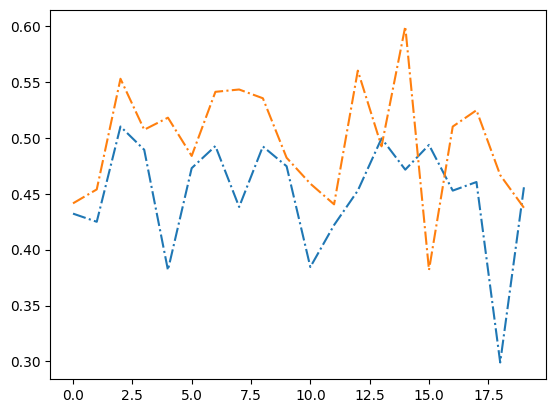

In [11]:
df_tmp = df[(df[["init_cond_idx", "t_samp_dist_idx"]]==0).all(axis=1)]
plt.plot(df_tmp[[i for i in df.columns if "sp" in i]], "-.")